# Estimating COVID-19's $R_t$ in Real-Time with PYMC3

Kevin Systrom - April 22

Model originally built by [Thomas Vladeck](https://github.com/tvladeck) in Stan, parts inspired by the work over at https://epiforecasts.io/, lots of help from [Thomas Wiecki](https://twitter.com/twiecki). Thank you to everyone who helped.

This notebook is a WIP - I'll add more context and commentary over the coming week.

In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import covsirphy as cs
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Load State Information
#### Load

In [2]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
ita_regions = pd.read_csv(url,
                     usecols=[0,3,17],
                     index_col=['denominazione_regione', 'data'],
                     parse_dates=['data'],
                     squeeze=True).sort_index()

In [3]:
ita_regions=ita_regions.to_frame()

#### Clean data with known modifications

## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [4]:
# import requests

# url = 'https://pypi.python.org/packages/source/x/xlrd/xlrd-0.9.4.tar.gz'
# target_path = 'xlrd-0.9.4.tar.gz'

# def download_file(url, local_filename):
#     """From https://stackoverflow.com/questions/16694907/"""
#     r = requests.get(url)
#     z = zipfile.ZipFile(io.BytesIO(r.content))
#     z.extractall(local_filename)
    
# #     with requests.get(url, stream=True) as r:
# #         r.raise_for_status()
# #         with open(local_filename, 'wb') as f:
# #             for chunk in r.iter_content(chunk_size=8192): 
# #                 if chunk: # filter out keep-alive new chunks
# #                     f.write(chunk)
#     return local_filename


# response = requests.get(URL, stream=True)
# if response.status_code == 200:
#     with open(LINELIST_PATH, 'wb') as f:
#         f.write(response.raw.read())

# # URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"

# if not os.path.exists(LINELIST_PATH):
#     print('Downloading file, this will take a while ~100mb')
#     try:
#         os.makedirs("data/", exist_ok = True)
#         download_file(URL, LINELIST_PATH)
#         clear_output(wait=True)
#         print('Done downloading.')
#     except:
#         print('Something went wrong. Try again.')
# else:
#     print('Already downloaded CSV')

In [5]:
# # Create DataLoader instance
# data_loader = cs.DataLoader("input")
# #download "linelist.csv" in folder "input"
# linelist = data_loader.linelist()


#### Parse & Clean Patient Info

In [6]:
# Load the patient CSV in the right path
patients = pd.read_csv(
    'data/latestdata.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

#### Show Relationship between Onset of Symptoms and Confirmation

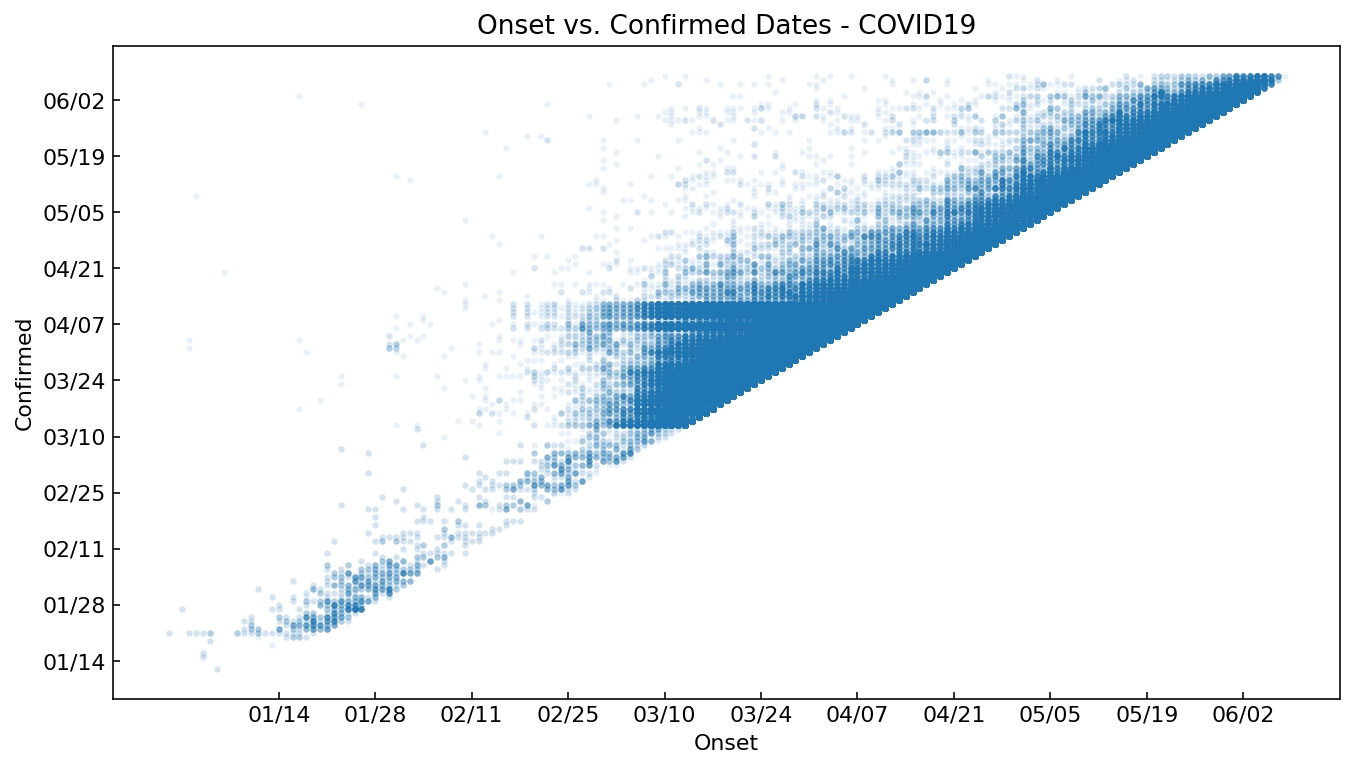

In [7]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(11,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

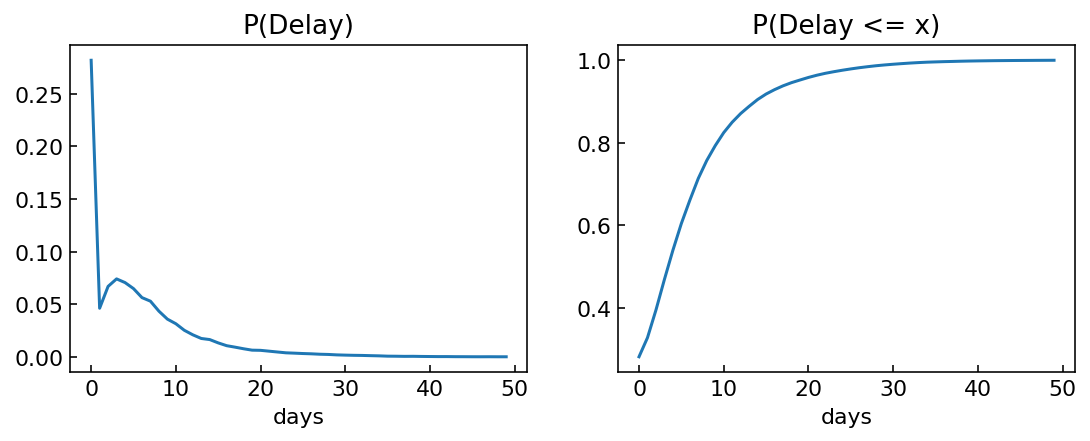

In [8]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

delay = delay[delay<50]

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

## A Single State

#### Select State Data

In [9]:
state = 'Basilicata'
confirmed = ita_regions.xs(state).totale_casi.diff().dropna()
confirmed.head()

data
2020-02-25 18:00:00    0.0
2020-02-26 18:00:00    0.0
2020-02-27 18:00:00    0.0
2020-02-28 18:00:00    0.0
2020-02-29 17:00:00    0.0
Name: totale_casi, dtype: float64

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [10]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset


onset = confirmed_to_onset(confirmed, p_delay)

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [11]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

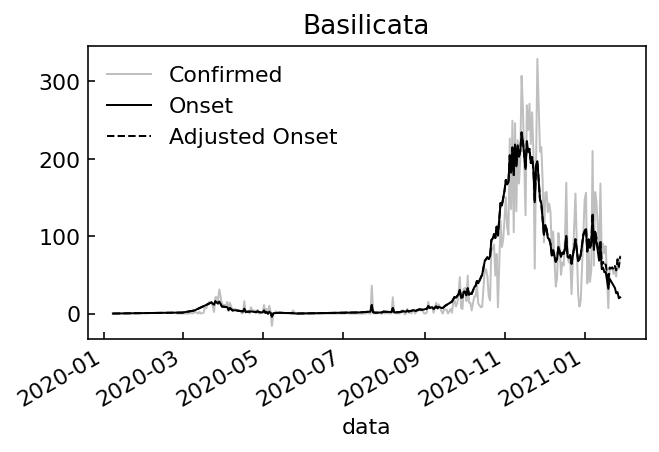

In [12]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=state,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

incidence must start: 2020-03-24

incidence must end  : 2021-01-08

first run was using:

+ self.onset = onset.loc[lower_date:upper_date]
+ self.cumulative_p_delay = cumulative_p_delay[lower_ind:upper_ind]
        

second run was using:

+ delta = datetime.today() - datetime.strptime("2020-03-24", '%Y-%m-%d')
+ window = delta.days
+ self.onset = onset.iloc[-window:]
+ self.cumulative_p_delay = cumulative_p_delay[-window:]

In [13]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=75):
        
        #My parameters that I need
        lower_date = datetime.strptime("2020-03-24", '%Y-%m-%d')
        upper_date = datetime.strptime("2021-01-08", '%Y-%m-%d')
        
        lower_ind = onset.index.strftime('%Y-%m-%d').get_loc(lower_date.strftime('%Y-%m-%d'))
        upper_ind = onset.index.strftime('%Y-%m-%d').get_loc(upper_date.strftime('%Y-%m-%d'))
        
        delta = datetime.today() - datetime.strptime("2020-03-24", '%Y-%m-%d')
        window = delta.days
        
        self.onset = onset.loc[lower_date:upper_date]
        self.cumulative_p_delay = cumulative_p_delay[lower_ind:upper_ind]
        
        # Just for identification purposes
        self.region = region
        
#         # For the model, we'll only look at the last N
#         self.onset = onset.iloc[-window:]
#         self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    ######################################################################
    ###################################  HERE ############################ 
    ######################################################################
    
    def run(self, chains=4, tune=2000, draws=4000, target_accept=.95):
    
    ######################################################################
    ###################################################################### 
    ######################################################################
    
        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sd=0.3)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.2, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)
            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            
            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)
            ######################################################################
            ###################################  HERE ############################ 
            ######################################################################
            
            for RV in model.basic_RVs:
                print(RV.name, RV.logp(model.test_point))
            
            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept,
                cores=-1)
            
            ######################################################################
            ###################################################################### 
            ######################################################################
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=4, tune=2000, draws=4000, target_accept=.8, cores=4)
        return self

### Run Pymc3 Model

In [14]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, .1)
    hpd_50 = pm.stats.hpd(r_t, .5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['denominazione_regione', 'data'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, state):
    confirmed = state.totale_casi.diff().dropna()
    #this is to avoid initialization errors, sometimes there is a drop and .diff() returns negative values
    #we choose to set them to zero.
    confirmed[confirmed < 0] = 0
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

In [15]:
models = {}
index  = 0

for state, grp in ita_regions.groupby('denominazione_regione'):
    index += 1
    print(state, "##", index, "/", len(ita_regions.groupby('denominazione_regione')))
    
    if state in models:
        print(f'Skipping {state}, already in cache')
        continue
    name=state
    models[state] = create_and_run_model(name, grp.droplevel(0))

Abruzzo ## 1 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 280 divergences: 100%|██████████| 2400/2400 [02:40<00:00, 14.92draws/s]
The acceptance probability does not match the target. It is 0.8849894859883309, but should be close to 0.95. Try to increase the number of tuning steps.
There were 255 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4657496553933812, but should be close to 0.95. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Basilicata ## 2 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [01:19<00:00, 30.09draws/s]


Calabria ## 3 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [02:01<00:00, 19.78draws/s]


Campania ## 4 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [04:12<00:00,  9.49draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Emilia-Romagna ## 5 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [04:29<00:00,  8.91draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Friuli Venezia Giulia ## 6 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [03:59<00:00, 10.04draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Lazio ## 7 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [03:56<00:00, 10.15draws/s]
The number of effective samples is smaller than 25% for some parameters.


Liguria ## 8 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [05:34<00:00,  7.18draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.904827032470104, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Lombardia ## 9 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [04:15<00:00,  9.40draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Marche ## 10 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [05:16<00:00,  7.59draws/s]
The number of effective samples is smaller than 25% for some parameters.


Molise ## 11 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [01:20<00:00, 29.82draws/s]


P.A. Bolzano ## 12 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [04:02<00:00,  9.88draws/s]
The acceptance probability does not match the target. It is 0.906651754868608, but should be close to 0.95. Try to increase the number of tuning steps.


P.A. Trento ## 13 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 18 divergences: 100%|██████████| 2400/2400 [01:18<00:00, 30.62draws/s]
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Piemonte ## 14 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [04:02<00:00,  9.90draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Puglia ## 15 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [04:03<00:00,  9.87draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8902028547388998, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Sardegna ## 16 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [01:52<00:00, 21.39draws/s]


Sicilia ## 17 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [04:14<00:00,  9.42draws/s]
The number of effective samples is smaller than 25% for some parameters.


Toscana ## 18 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [04:30<00:00,  8.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


Umbria ## 19 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [04:42<00:00,  8.50draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Valle d'Aosta ## 20 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [01:11<00:00, 33.75draws/s]


Veneto ## 21 / 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [04:21<00:00,  9.18draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


### Handle Divergences

In [16]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging states:')
display(divergences[has_divergences])

# Rerun states with divergences
for state, n_divergences in divergences[has_divergences].items():
    models[state].run()

Diverging states:


Abruzzo        280
P.A. Trento     18
dtype: int64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 152 divergences: 100%|██████████| 2400/2400 [02:10<00:00, 18.37draws/s]
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8062687986796583, but should be close to 0.95. Try to increase the number of tuning steps.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8392964725819226, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using ji

## Compile Results

In [17]:
results = None

for state, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

In [18]:
results.loc['Veneto']

,mean,median,lower_90,upper_90,lower_50,upper_50
data,,,,,,
2020-03-26 17:00:00,1.009382,1.006129,0.967828,1.001045,0.901859,1.094765
2020-03-27 17:00:00,1.035776,1.030524,1.015833,1.047331,0.922563,1.112739
2020-03-28 17:00:00,0.721560,0.768550,0.794451,0.830283,0.716393,0.946754
2020-03-29 17:00:00,0.899783,0.921897,0.957487,0.992365,0.859111,1.070933
2020-03-30 17:00:00,0.840778,0.862195,0.935168,0.975211,0.785801,1.006318
...,...,...,...,...,...,...
2021-01-23 17:00:00,0.869369,0.891607,0.937650,0.965402,0.804974,0.985175
2021-01-24 17:00:00,0.943202,0.953762,0.977158,1.007481,0.876311,1.062573
2021-01-25 17:00:00,0.468491,0.524798,0.615491,0.672130,0.445475,0.775345


### Render to CSV
Uncomment if you'd like

In [19]:
results.to_csv('data/MCMC_Rt_2nd_way.csv')

### Render Charts

In [20]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(0.5, 1.6)
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_50'].values,
        result['upper_50'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
#     ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

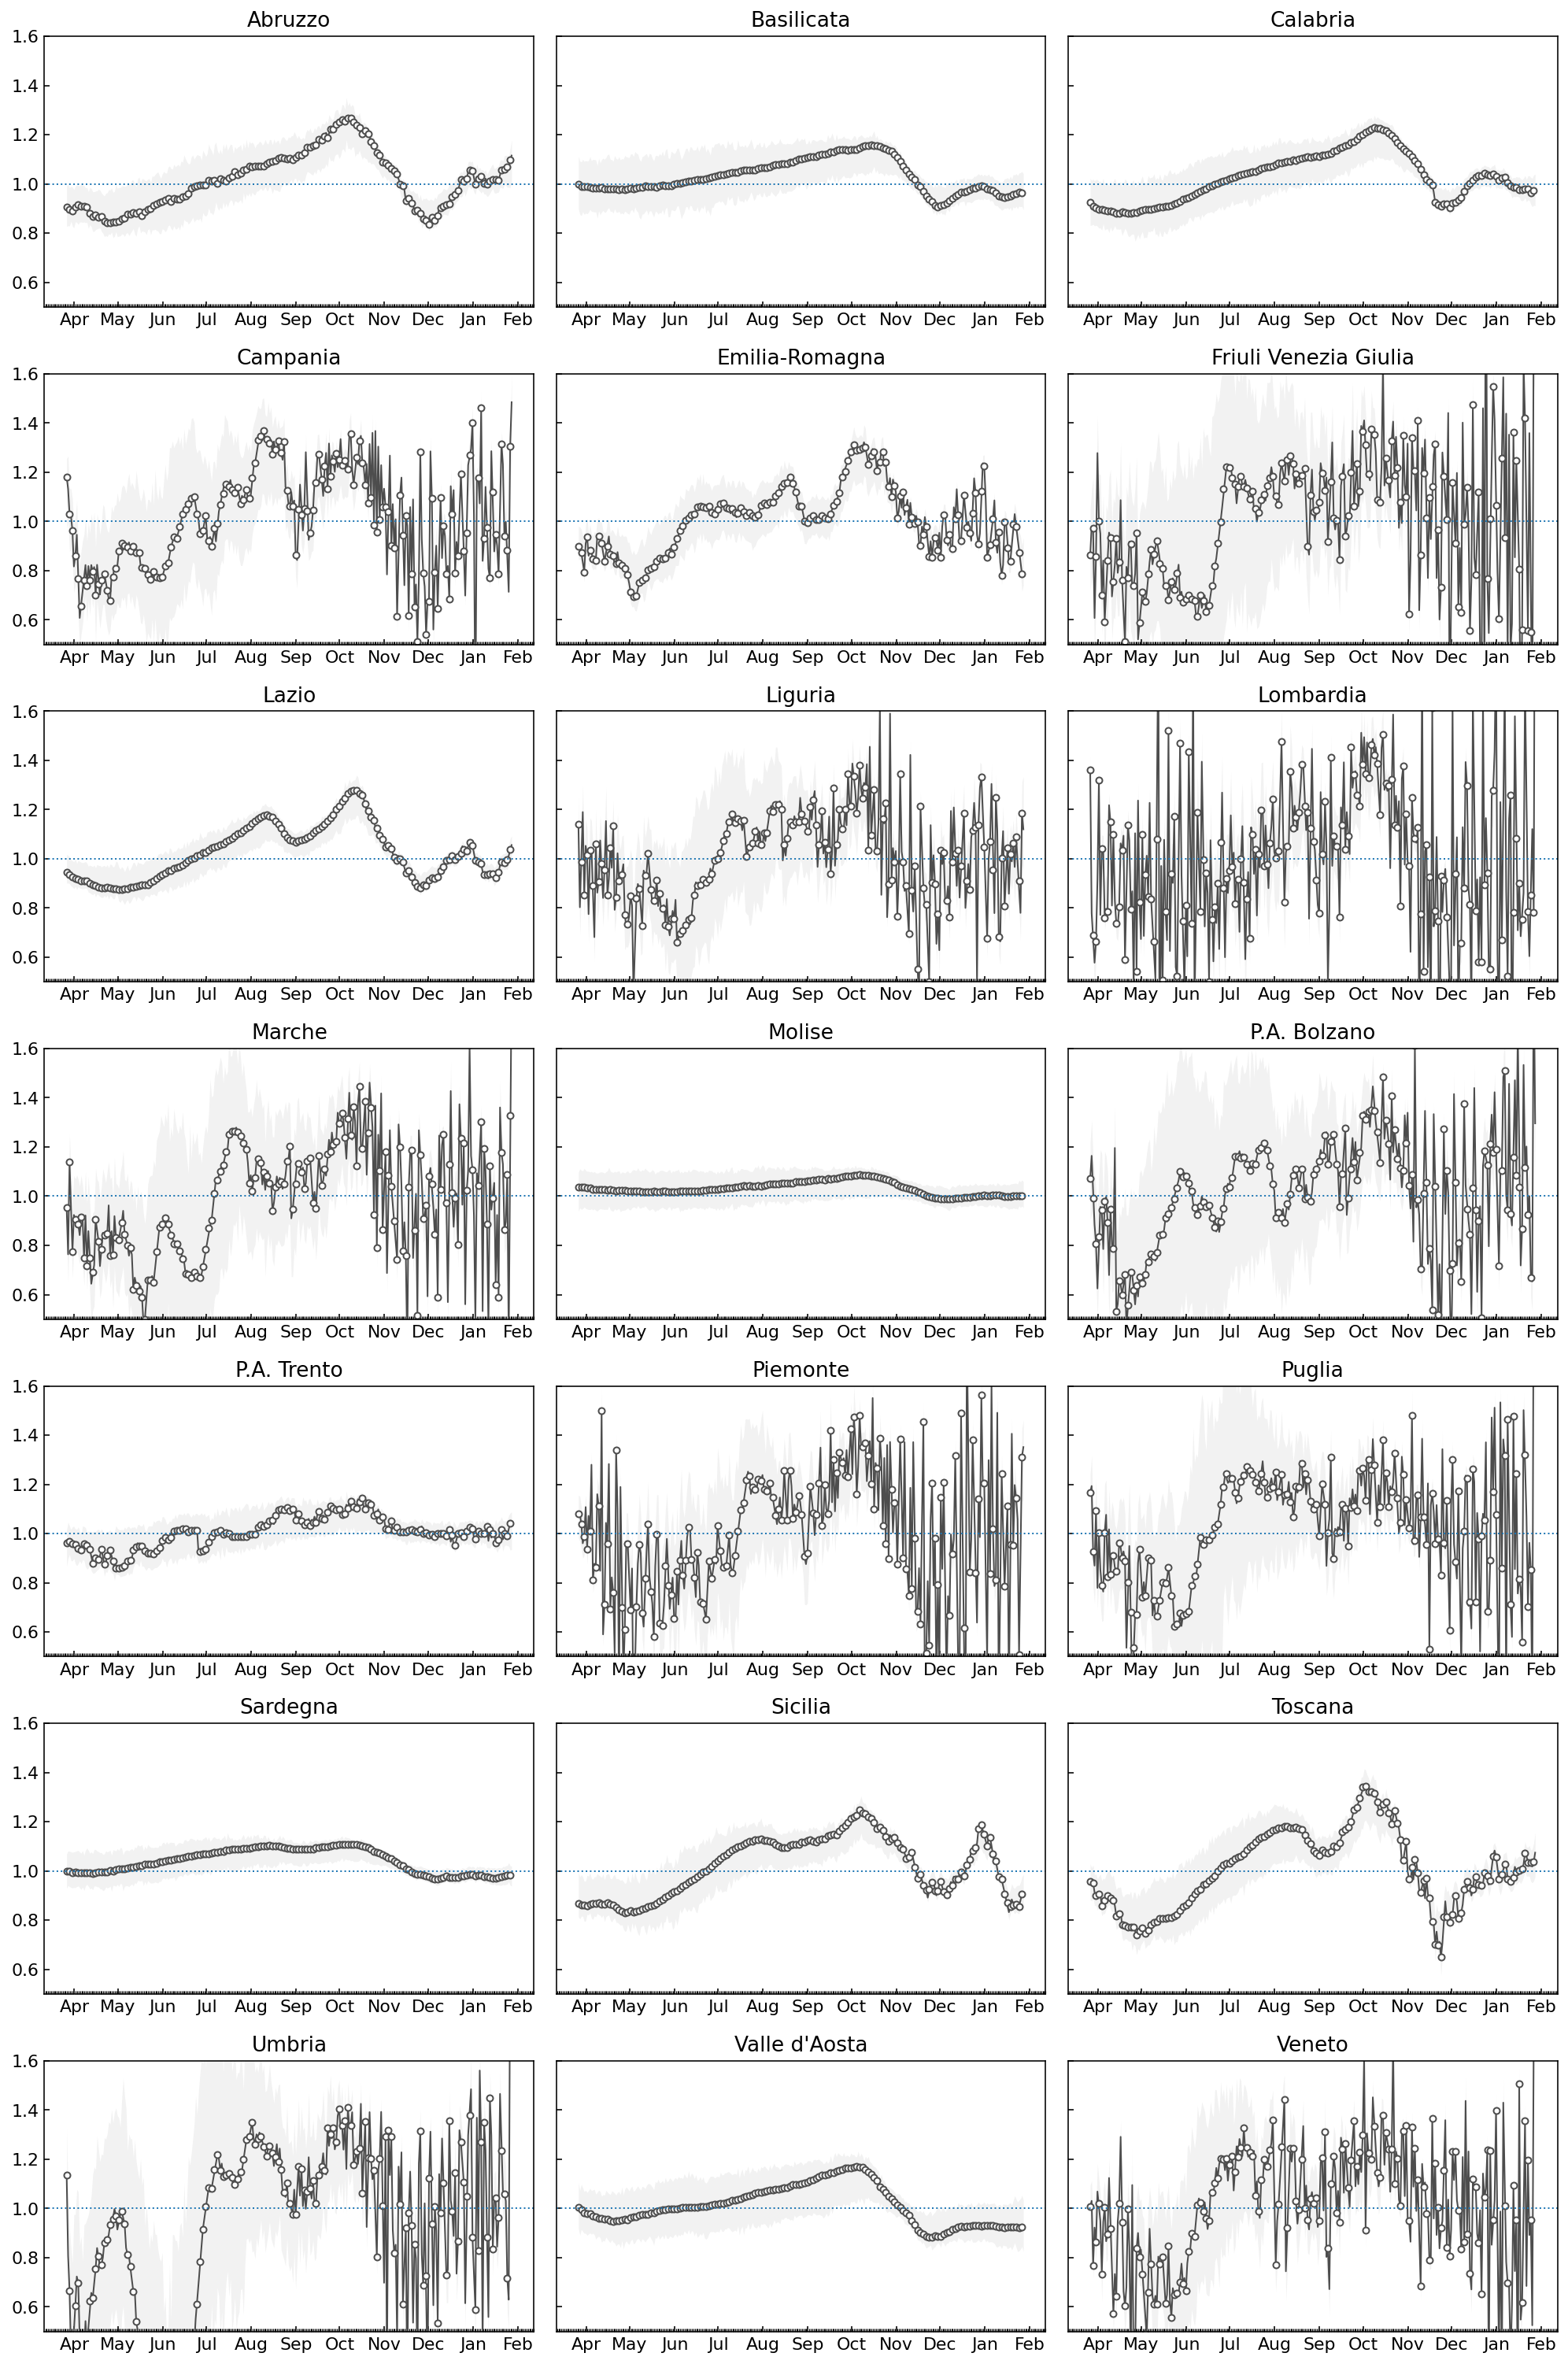

In [21]:
ncols = 3
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (state, result) in zip(axes.flat, results.groupby('denominazione_regione')):
    plot_rt(state, result.droplevel(0), ax)
    
fig.tight_layout()
fig.set_facecolor('w')
plt.savefig('Figures/Regioni_Rt_2nd.png')

In [2]:
# url = 'https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv'
# abbrev = pd.read_csv(url, index_col=['State'], squeeze=True)

# jhu_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
# jhu = pd.read_csv(jhu_url)

# jhu = jhu.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
# jhu = jhu.set_index('Province_State')
# jhu.index = jhu.index.rename('region')
# jhu = jhu.drop([
#     'American Samoa',
#     'Guam',
#     'Northern Mariana Islands',
#     'Puerto Rico',
#     'Virgin Islands',
#     'Diamond Princess',
#     'Grand Princess'])

# jhu.index = pd.Index(jhu.index.to_series().replace(abbrev).values, name='region')
# jhu.columns = pd.to_datetime(jhu.columns)
# jhu = jhu.groupby('region').sum()
# jhu = jhu.stack().sort_index()

# state = 'VT'
# ax = jhu.xs(state).diff().plot(label='JHU', color='k', legend=True, title=state)
# # jhu.xs('AK').diff().rolling(7).mean().plot(ax=ax)
# states.xs(state).positive.diff().plot(ax=ax, figsize=(6,4), linestyle=':', label='Covidtracking', legend=True)
# ax.set_xlim(pd.Timestamp('2020-03-01'),None)

In [3]:
# url = 'https://raw.githubusercontent.com/epiforecasts/covid-regional/3ad63ea1acceb797f0628a8037fc206342d267e7/united-states/regional-summary/rt.csv'

# epf = pd.read_csv(url, parse_dates=['date'])
# epf.region = epf.region.replace(abbrev)
# epf = epf.set_index(['region', 'date']).sort_index()
# epf = epf.drop(['Guam', 'Puerto Rico'])

# epf_lookup = {}
# for idx, grp in epf.groupby('region'):

#     epf_lookup[idx]=grp
#     epf_grp = epf_lookup[state]
    
#     plot_rt(state, result.droplevel(0), ax)
#     plot_rt(state, epf_grp.droplevel(0), ax, c=(1,0,0,1))

In [4]:
import seaborn as sns

In [5]:
today=str(pd.to_datetime('today').date())

NameError: name 'pd' is not defined

In [6]:
ERROR_BAR_COLOR = [.3,.3,.3]

In [7]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Region', fontsize=14):
    #if not figsize:
    #    figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=(15,7))

    ax.set_title(title)
    err = mr[['lower_50', 'upper_50']].sub(mr['median'], axis=0).abs()
    bars = sns.barplot(mr.index,
                  mr['median'],
                  #width=.825,
                  #color=mr.ML.values,
                  ecolor=ERROR_BAR_COLOR,
                  palette='magma',
    
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    #for bar, state_name in zip(bars, mr.index):
    #    if state_name in no_lockdown:
    #        bar.set_color(NONE_COLOR)
    #    if state_name in partial_lockdown:
    #        bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,1.5)
    plt.yticks(fontsize=18)
    plt.ylabel("")
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
    ax.set_xticklabels(labels, fontsize=18)


    #leg = ax.legend(handles=[
    #                    Patch(label='Full', color=FULL_COLOR),
    #                    Patch(label='Partial', color=PARTIAL_COLOR),
    #                    Patch(label='None', color=NONE_COLOR)
    #                ],
    #                title='Lockdown',
    #                ncol=3,
    #                loc='upper left',
    #                columnspacing=.75,
    #                handletextpad=.5,
    #                handlelength=1)

    #leg._legend_box.align = "left"
    #fig.set_facecolor('w')
    plt.savefig('/Users/Michele/Desktop/Rt_Italian_regions_standings_'+today+'.png', bbox_inches='tight')
    return fig, ax

filtered=[]
mr = results.groupby(level=0)[['median', 'upper_50', 'lower_50']].last()

mr.sort_values('median', inplace=True)
plot_standings(mr)


NameError: name 'results' is not defined

In [90]:
mr

,median,upper_50,lower_50
denominazione_regione,,,
Umbria,0.748186,1.110497,0.550507
P.A. Bolzano,0.799711,1.101516,0.717709
Veneto,0.836017,0.981750,0.744518
Marche,0.840185,1.031487,0.716688
Calabria,0.841761,1.151373,0.686819
Campania,0.842038,1.046887,0.718492
Puglia,0.855778,1.052226,0.773113
Toscana,0.881688,0.993939,0.739946
Sicilia,0.884554,1.100318,0.764107
